In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
pip install pgmpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 29.9 MB/s eta 0:00:00


In [ ]:
from pgmpy.estimators import HillClimbSearch, BicScore, MaximumLikelihoodEstimator, BayesianEstimator
from pgmpy.models import BayesianModel, BayesianNetwork
from pgmpy.sampling import GibbsSampling
from pgmpy.inference import VariableElimination
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import roc_auc_score, roc_curve

import multiprocessing as mp
import networkx as nx
import matplotlib.pyplot as plt

In [ ]:
# import data / data preprocessing
df = pd.read_csv('METABRIC_RNA_Mutation.csv')
df.drop('patient_id', axis = 1)

<ipython-input-4-5903a8170567>:2: DtypeWarning: Columns (678,688,690,692) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('METABRIC_RNA_Mutation.csv')


,age_at_diagnosis,type_of_breast_surgery,cancer_type,cancer_type_detailed,cellularity,chemotherapy,pam50_+_claudin-low_subtype,cohort,er_status_measured_by_ihc,er_status,...,mtap_mut,ppp2cb_mut,smarcd1_mut,nras_mut,ndfip1_mut,hras_mut,prps2_mut,smarcb1_mut,stmn2_mut,siah1_mut
0,75.65,MASTECTOMY,Breast Cancer,Breast Invasive Ductal Carcinoma,NaN,0,claudin-low,1.0,Positve,Positive,...,0,0,0,0,0,0,0,0,0,0
1,43.19,BREAST CONSERVING,Breast Cancer,Breast Invasive Ductal Carcinoma,High,0,LumA,1.0,Positve,Positive,...,0,0,0,0,0,0,0,0,0,0
2,48.87,MASTECTOMY,Breast Cancer,Breast Invasive Ductal Carcinoma,High,1,LumB,1.0,Positve,Positive,...,0,0,0,0,0,0,0,0,0,0
3,47.68,MASTECTOMY,Breast Cancer,Breast Mixed Ductal and Lobular Carcinoma,Moderate,1,LumB,1.0,Positve,Positive,...,0,0,0,0,0,0,0,0,0,0
4,76.97,MASTECTOMY,Breast Cancer,Breast Mixed Ductal and Lobular Carcinoma,High,1,LumB,1.0,Positve,Positive,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1899,43.10,BREAST CONSERVING,Breast Cancer,Breast Invasive Lobular Carcinoma,High,0,LumA,4.0,Positve,Positive,...,0,0,0,0,0,0,0,0,0,0
1900,42.88,MASTECTOMY,Breast Cancer,Breast Invasive Ductal Carcinoma,High,0,LumB,4.0,Positve,Positive,...,0,0,0,0,0,0,0,0,0,0
1901,62.90,MASTECTOMY,Breast Cancer,Breast Invasive Ductal Carcinoma,High,0,LumB,4.0,Positve,Positive,...,0,0,0,0,0,0,0,0,0,0
1902,61.16,MASTECTOMY,Breast Cancer,Breast Invasive Ductal Carcinoma,Moderate,0,LumB,4.0,Positve,Positive,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# dropping mutations
genetic_features_to_drop = df.columns[520:]
genetic_df = df.drop(genetic_features_to_drop, axis=1)
# droping clinical data
genetic_features_to_drop = genetic_df.columns[4:35]
genetic_df = genetic_df.drop(genetic_features_to_drop, axis=1)
genetic_df = genetic_df.drop(['age_at_diagnosis','type_of_breast_surgery', 'cancer_type'], axis=1)
genetic_df = genetic_df.iloc [:,:-174]
genetic_df['overall_survival']= df['overall_survival']

genetic_df.head()

,patient_id,tp53,atm,cdh1,chek2,nbn,nf1,stk11,bard1,mlh1,...,tubb4a,tubb4b,twist1,adgra2,afdn,aff2,agmo,agtr2,ahnak,overall_survival
0,0,0.3504,1.1517,0.0348,0.1266,-0.8361,-0.8578,-0.4294,-1.1201,-0.4844,...,-0.0250,-0.4113,2.8096,2.8014,-0.0004,0.9673,0.3011,-0.8436,1.8227,1
1,2,-0.0136,-0.2659,1.3594,0.7961,0.5419,-2.6059,0.5120,0.4390,1.2266,...,-0.1003,0.7791,-0.2273,-0.4462,-1.9854,0.5022,-0.9526,-1.8435,1.6662,1
2,5,0.5141,-0.0803,1.1398,0.4187,-0.4030,-1.1305,0.2362,-0.1721,-1.7910,...,1.2084,-0.6572,0.1984,-1.0721,-0.9729,0.0515,0.1109,0.9874,-0.0154,0
3,6,1.6708,-0.8880,1.2491,-1.1889,-0.4174,-0.6165,1.0078,-0.4010,-1.3905,...,0.3142,-0.4413,0.1932,-1.0215,0.4553,-0.2354,0.4003,1.4839,0.3101,1
4,8,0.3484,0.3897,0.9131,0.9356,0.7675,-0.2940,-0.2961,0.6320,-0.3582,...,-0.6606,-1.4697,0.4128,-1.5326,-0.4795,1.0052,0.9739,0.8825,-0.7598,0


In [ ]:
#Finding Maximum values and std in each column, std is always 1 because the datapoints are z-scores
max_values = genetic_df.max()
std = genetic_df.std(axis = 0, skipna = True)
max_data = pd.concat([max_values, std], axis = 1, keys = ['max_values', 'std'])
max_data.sort_values(by='max_values', ascending = False).head()

,max_values,std
patient_id,7299.0000,2358.478332
tubb4a,18.6351,1.000263
hes5,17.1431,1.000262
itgb3,15.3308,1.000263
slco1b3,14.8651,1.000262


In [ ]:
#Finding minimum values and std in each column, std is always 1 because the datapoints are z-scores
min_values = genetic_df.min()
std = genetic_df.std(axis = 0, skipna = True)
min_data = pd.concat([min_values, std], axis = 1, keys = ['min_values', 'std'])
min_data.sort_values(by='min_values', ascending = True).head()

,min_values,std
mlh1,-6.4387,1.000262
rab25,-6.3503,1.000264
hdac1,-5.9821,1.000263
spen,-5.9510,1.000263
foxo3,-5.7543,1.000263


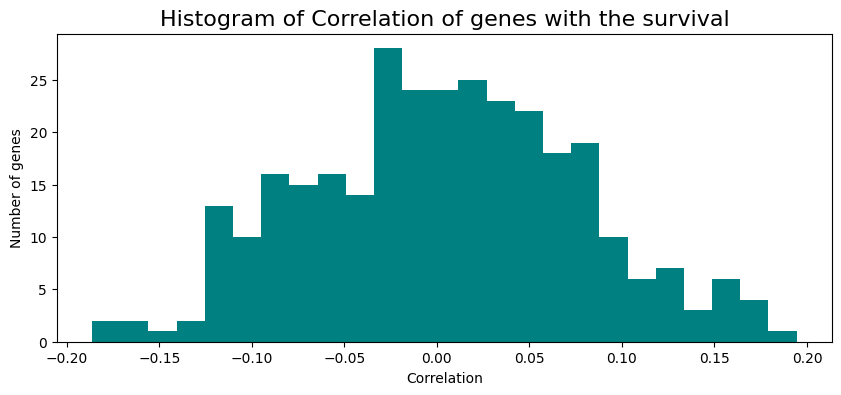

In [ ]:
#how varied are genes and how well do they correlate with eventdeath?
fig, ax = plt.subplots(figsize=(10,4))

#plot histogram of variation using standard deviation as a measure
corrs=[]
for col in genetic_df.drop(['patient_id'], axis = 1).columns:
    corr = genetic_df[[col,'overall_survival']].corr()['overall_survival'][col]
    corrs.append(corr)

corrs.pop(-1)
ax.hist(corrs,  bins=25, color = 'teal')
ax.set_xlabel("Correlation")
ax.set_ylabel("Number of genes")
ax.set_title("Histogram of Correlation of genes with the survival", size=16)


plt.show()


In [ ]:
# Calculate the correlation of each gene with overall survival
corrs = {}
for col in genetic_df.drop(['patient_id', 'overall_survival'], axis=1).columns:
    corr = genetic_df[[col, 'overall_survival']].corr()['overall_survival'][col]
    corrs[col] = corr

# List columns where the correlation is between -0.1 and 0.1
low_corr_columns = [col for col, corr in corrs.items() if -0.1 <= corr <= 0.1]

print("Columns with correlation between -0.1 and 0.1:", low_corr_columns)
len(low_corr_columns)

Columns with correlation between -0.1 and 0.1: ['tp53', 'atm', 'cdh1', 'chek2', 'nbn', 'nf1', 'stk11', 'mlh1', 'msh2', 'msh6', 'epcam', 'rad51c', 'rad51d', 'rad50', 'rbl1', 'rbl2', 'ccna1', 'cdk1', 'ccne1', 'cdk2', 'cdc25a', 'ccnd1', 'cdk4', 'cdk6', 'cdkn2a', 'cdkn2b', 'cdkn1a', 'cdkn1b', 'e2f1', 'e2f2', 'e2f3', 'e2f4', 'e2f5', 'e2f6', 'e2f7', 'e2f8', 'src', 'stat1', 'stat3', 'stat5b', 'mdm2', 'tp53bp1', 'adam17', 'aph1a', 'aph1b', 'arrdc1', 'cir1', 'ctbp1', 'ctbp2', 'cul1', 'dll1', 'dll3', 'dll4', 'dtx1', 'dtx2', 'dtx4', 'ep300', 'fbxw7', 'hdac1', 'hdac2', 'hes1', 'hes5', 'heyl', 'itch', 'jag1', 'jag2', 'kdm5a', 'lfng', 'maml2', 'maml3', 'ncor2', 'ncstn', 'notch1', 'notch2', 'nrarp', 'numb', 'numbl', 'psen2', 'psenen', 'rbpj', 'rbpjl', 'rfng', 'snw1', 'spen', 'hes2', 'hes4', 'hes7', 'hey1', 'hey2', 'acvr1', 'acvr1b', 'acvr1c', 'acvr2a', 'acvr2b', 'acvrl1', 'akt2', 'apaf1', 'arl11', 'atr', 'aurka', 'bad', 'bcl2', 'bmp10', 'bmp15', 'bmp2', 'bmp3', 'bmp4', 'bmp5', 'bmp7', 'bmpr1a', 'bmpr

259

In [ ]:
genetic_df = genetic_df.drop(['tp53', 'atm', 'cdh1', 'chek2', 'nbn', 'nf1', 'stk11', 'mlh1', 'msh2', 'msh6', 'epcam', 'rad51c', 'rad51d', 'rad50', 'rbl1', 'rbl2', 'ccna1', 'cdk1', 'ccne1', 'cdk2', 'cdc25a', 'ccnd1', 'cdk4', 'cdk6', 'cdkn2a', 'cdkn2b', 'cdkn1a', 'cdkn1b', 'e2f1', 'e2f2', 'e2f3', 'e2f4', 'e2f5', 'e2f6', 'e2f7', 'e2f8', 'src', 'stat1', 'stat3', 'stat5b', 'mdm2', 'tp53bp1', 'adam17', 'aph1a', 'aph1b', 'arrdc1', 'cir1', 'ctbp1', 'ctbp2', 'cul1', 'dll1', 'dll3', 'dll4', 'dtx1', 'dtx2', 'dtx4', 'ep300', 'fbxw7', 'hdac1', 'hdac2', 'hes1', 'hes5', 'heyl', 'itch', 'jag1', 'jag2', 'kdm5a', 'lfng', 'maml2', 'maml3', 'ncor2', 'ncstn', 'notch1', 'notch2', 'nrarp', 'numb', 'numbl', 'psen2', 'psenen', 'rbpj', 'rbpjl', 'rfng', 'snw1', 'spen', 'hes2', 'hes4', 'hes7', 'hey1', 'hey2', 'acvr1', 'acvr1b', 'acvr1c', 'acvr2a', 'acvr2b', 'acvrl1', 'akt2', 'apaf1', 'arl11', 'atr', 'aurka', 'bad', 'bcl2', 'bmp10', 'bmp15', 'bmp2', 'bmp3', 'bmp4', 'bmp5', 'bmp7', 'bmpr1a', 'bmpr1b', 'bmpr2', 'braf', 'casp10', 'casp3', 'casp7', 'casp9', 'chek1', 'csf1', 'csf1r', 'cxcl8', 'cxcr1', 'cxcr2', 'dab2', 'diras3', 'dlec1', 'dph1', 'egfr', 'eif4ebp1', 'eif5a2', 'erbb2', 'erbb3', 'fgfr1', 'folr1', 'folr3', 'foxo1', 'foxo3', 'gdf11', 'gdf2', 'hif1a', 'hla-g', 'hras', 'igf1r', 'inha', 'inhba', 'inhbc', 'itgav', 'itgb3', 'izumo1r', 'kdr', 'kras', 'map2k1', 'map2k3', 'map2k4', 'map2k5', 'map3k1', 'map3k3', 'map3k4', 'map3k5', 'mapk1', 'mapk12', 'mapk3', 'mapk4', 'mapk6', 'mapk7', 'mapk8', 'mapk9', 'mdc1', 'mlst8', 'mmp1', 'mmp10', 'mmp12', 'mmp13', 'mmp14', 'mmp16', 'mmp17', 'mmp19', 'mmp2', 'mmp21', 'mmp23b', 'mmp24', 'mmp25', 'mmp26', 'mmp27', 'mmp28', 'mmp3', 'mmp9', 'mtor', 'nfkb1', 'nfkb2', 'opcml', 'pdgfa', 'pdgfrb', 'pdpk1', 'peg3', 'pik3ca', 'pik3r1', 'pik3r2', 'plagl1', 'ptk2', 'rab25', 'rad51', 'raf1', 'rassf1', 'rictor', 'rps6ka1', 'rps6ka2', 'rps6kb1', 'smad1', 'smad2', 'smad5', 'smad6', 'smad7', 'smad9', 'sptbn1', 'terc', 'tert', 'tgfb1', 'tgfb2', 'tgfb3', 'tgfbr1', 'tgfbr3', 'tsc1', 'vegfa', 'vegfb', 'wfdc2', 'zfyve9', 'arid1b', 'cbfb', 'gata3', 'kmt2d', 'myh9', 'ncor1', 'pde4dip', 'ptprd', 'ros1', 'runx1', 'tbx3', 'abcb11', 'abcc1', 'abcc10', 'bbc3', 'bmf', 'cyp2c8', 'cyp3a4', 'fgf2', 'fn1', 'map2', 'mapt', 'nr1i2', 'slco1b3', 'tubb1', 'tubb4a', 'twist1', 'adgra2', 'aff2', 'agmo', 'agtr2', 'ahnak'], axis=1)
genetic_df.head()

,patient_id,bard1,pms2,rb1,ccnb1,ccnd2,myc,jak1,jak2,stat2,...,tgfbr2,tsc2,wwox,arid1a,kmt2c,abcb1,map4,tubb4b,afdn,overall_survival
0,0,-1.1201,-0.1250,-0.2770,-1.6635,1.4313,2.5602,1.1097,1.6186,-0.7556,...,2.2907,-0.7012,-0.4464,-1.2999,-0.9045,1.6758,-0.3917,-0.4113,-0.0004,1
1,2,0.4390,1.0104,-1.7488,-0.2715,0.0546,0.7248,0.9804,-0.0104,-0.7991,...,-0.6814,-0.6919,-0.8286,1.9157,-0.0208,-1.1793,0.9038,0.7791,-1.9854,1
2,5,-0.1721,2.6127,1.4142,0.6967,0.8958,-0.7207,1.5835,0.7379,-1.3487,...,0.2776,-1.3444,-0.3171,-0.9847,-0.5063,-0.4457,-0.6845,-0.6572,-0.9729,0
3,6,-0.4010,2.9414,1.5345,1.8801,1.1455,-0.5237,0.6194,0.8552,-0.5512,...,1.0795,-0.9989,-0.4584,-1.5992,-1.2840,-0.8191,-1.0618,-0.4413,0.4553,1
4,8,0.6320,0.6323,1.0158,0.2862,-1.0195,0.5223,0.0461,0.1645,0.3308,...,-0.2670,0.4206,0.1638,0.5634,-1.1026,-0.3463,-0.2336,-1.4697,-0.4795,0


In [ ]:
# discritize mRNA z-scores into Low, Medium, High
# Low = less than -2, High = greater than 2, Medium = between -2 and 2 (we can change these ranges if needed)
# define the column range from 'brca1' to 'ugt2b7' (mRNA z-scores)

# get the column names within the specified range
columns_to_discretize = genetic_df.loc[:,'bard1':'afdn'].columns

# apply discretization
genetic_df[columns_to_discretize] = genetic_df[columns_to_discretize].apply(lambda col: pd.cut(col, bins=[-float('inf'), -2, 2, float('inf')],
                                                                                             labels=[0, 1, 2]))
print(genetic_df)


      patient_id bard1 pms2 rb1 ccnb1 ccnd2 myc jak1 jak2 stat2  ... tgfbr2  \
0              0     1    1   1     1     1   2    1    1     1  ...      2   
1              2     1    1   1     1     1   1    1    1     1  ...      1   
2              5     1    2   1     1     1   1    1    1     1  ...      1   
3              6     1    2   1     1     1   1    1    1     1  ...      1   
4              8     1    1   1     1     1   1    1    1     1  ...      1   
...          ...   ...  ...  ..   ...   ...  ..  ...  ...   ...  ...    ...   
1899        7295     1    1   1     1     1   1    1    1     1  ...      1   
1900        7296     1    1   1     2     1   1    1    1     1  ...      1   
1901        7297     1    1   1     1     1   2    1    1     1  ...      1   
1902        7298     1    2   1     1     1   1    1    1     1  ...      1   
1903        7299     1    2   1     1     1   1    1    1     1  ...      1   

     tsc2 wwox arid1a kmt2c abcb1 map4 tubb4b afdn 

In [ ]:
discretized_df = genetic_df.drop(['patient_id'], axis = 1)
discretized_df.head()

,bard1,pms2,rb1,ccnb1,ccnd2,myc,jak1,jak2,stat2,stat5a,...,tgfbr2,tsc2,wwox,arid1a,kmt2c,abcb1,map4,tubb4b,afdn,overall_survival
0,1,1,1,1,1,2,1,1,1,2,...,2,1,1,1,1,1,1,1,1,1
1,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
2,1,2,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,0
3,1,2,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
4,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,0


  0%|          | 0/1000000 [00:00<?, ?it/s]

Edges of the Estimated DAG:
[('myc', 'kit'), ('jak1', 'adam10'), ('jak1', 'tgfbr2'), ('jak1', 'rb1'), ('jak1', 'wwox'), ('adam10', 'eif4e'), ('adam10', 'dtx3'), ('adam10', 'afdn'), ('adam10', 'mapk14'), ('eif4e', 'pms2'), ('eif4e', 'map2k2'), ('eif4e', 'casp6'), ('eif4e', 'rps6'), ('fas', 'jak2'), ('fgf1', 'pdgfra'), ('gsk3b', 'mmp15'), ('gsk3b', 'overall_survival'), ('igf1', 'fas'), ('igf1', 'tubb4b'), ('kit', 'fgf1'), ('kit', 'bmp6'), ('map2k2', 'rps6kb2'), ('mmp15', 'akt1'), ('mmp15', 'slc19a1'), ('mmp7', 'bcl2l1'), ('pdgfra', 'igf1'), ('rheb', 'jak1'), ('rheb', 'akt1s1'), ('rheb', 'smad4'), ('rheb', 'myc'), ('rheb', 'gsk3b'), ('rheb', 'rptor'), ('rheb', 'stat2'), ('rheb', 'mmp7'), ('rheb', 'ccnb1'), ('smad3', 'pdgfb'), ('tgfbr2', 'arid1a'), ('tgfbr2', 'erbb4'), ('tgfbr2', 'abcb1'), ('tgfbr2', 'folr2'), ('tgfbr2', 'smad3'), ('tgfbr2', 'casp8'), ('tsc2', 'notch3'), ('tsc2', 'igf1'), ('arid1a', 'tsc2'), ('arid1a', 'maml1'), ('abcb1', 'kit'), ('abcb1', 'ccnd2'), ('abcb1', 'mmp11'), ('m

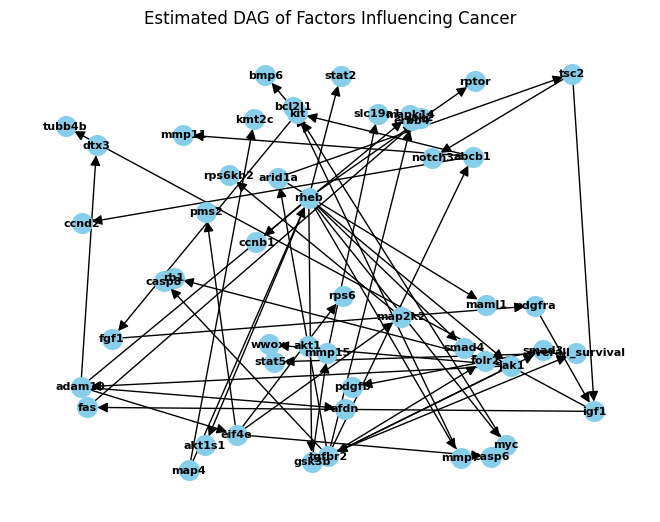

  0%|          | 0/1000000 [00:00<?, ?it/s]

Edges of the Estimated DAG:
[('myc', 'kit'), ('jak1', 'adam10'), ('jak1', 'tgfbr2'), ('jak1', 'rb1'), ('jak1', 'wwox'), ('adam10', 'eif4e'), ('adam10', 'dtx3'), ('adam10', 'afdn'), ('adam10', 'mapk14'), ('eif4e', 'pms2'), ('eif4e', 'map2k2'), ('eif4e', 'casp6'), ('eif4e', 'rps6'), ('fas', 'jak2'), ('fgf1', 'pdgfra'), ('gsk3b', 'mmp15'), ('gsk3b', 'overall_survival'), ('igf1', 'fas'), ('igf1', 'tubb4b'), ('kit', 'fgf1'), ('kit', 'bmp6'), ('map2k2', 'rps6kb2'), ('mmp15', 'akt1'), ('mmp15', 'slc19a1'), ('mmp7', 'bcl2l1'), ('pdgfra', 'igf1'), ('rheb', 'jak1'), ('rheb', 'akt1s1'), ('rheb', 'smad4'), ('rheb', 'myc'), ('rheb', 'gsk3b'), ('rheb', 'rptor'), ('rheb', 'stat2'), ('rheb', 'mmp7'), ('rheb', 'ccnb1'), ('smad3', 'pdgfb'), ('tgfbr2', 'arid1a'), ('tgfbr2', 'erbb4'), ('tgfbr2', 'abcb1'), ('tgfbr2', 'folr2'), ('tgfbr2', 'smad3'), ('tgfbr2', 'casp8'), ('tsc2', 'notch3'), ('tsc2', 'igf1'), ('arid1a', 'tsc2'), ('arid1a', 'maml1'), ('abcb1', 'kit'), ('abcb1', 'ccnd2'), ('abcb1', 'mmp11'), ('m

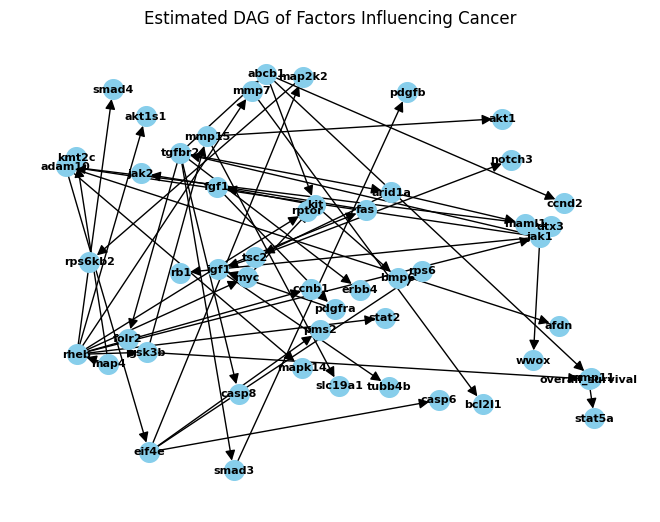

Processing fold 1/5...
AUC score for fold 1: 0.527588813303099
Processing fold 2/5...
AUC score for fold 2: 0.5289573143619387
Processing fold 3/5...
AUC score for fold 3: 0.5321098346875874
Processing fold 4/5...
AUC score for fold 4: 0.5246866096866097
Processing fold 5/5...
AUC score for fold 5: 0.5358149065141296
Average AUC score across 5 folds: 0.530


In [ ]:
from pgmpy.estimators import HillClimbSearch, BicScore
from pgmpy.models import BayesianNetwork
from pgmpy.sampling import BayesianModelSampling
from pgmpy.estimators import ParameterEstimator, BayesianEstimator
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np


# Define the Hill Climbing Search algorithm with BIC scoring
hc = HillClimbSearch(discretized_df)
best_model = hc.estimate(scoring_method=BicScore(discretized_df))

# Print the edges of the estimated DAG
print("Edges of the Estimated DAG:")
print(best_model.edges())

# Draw the DAG
edges = best_model.edges()
G = nx.DiGraph()
G.add_edges_from(edges)
pos = nx.random_layout(G)
nx.draw(G, pos, with_labels=True, font_weight='bold', node_size=200, node_color='skyblue', font_size=8, arrowsize=15)
plt.title("Estimated DAG of Factors Influencing Cancer")
plt.show()

# Assuming discretized_df is your preprocessed DataFrame (with discretized values for genes and 'overall_survival')

# Step 1: Set up k-fold cross-validation
k = 5  # You can choose a different value for k (e.g., 5 or 10)
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# To store AUC scores for each fold
auc_scores = []

# Step 2: Learn the structure on the entire dataset (once for all folds)
hc = HillClimbSearch(discretized_df)
best_model = hc.estimate(scoring_method=BicScore(discretized_df))

# Step 3: Visualize the learned structure (DAG)
edges = best_model.edges()
print("Edges of the Estimated DAG:")
print(edges)

# Draw the DAG
G = nx.DiGraph()
G.add_edges_from(edges)
pos = nx.random_layout(G)
nx.draw(G, pos, with_labels=True, font_weight='bold', node_size=200, node_color='skyblue', font_size=8, arrowsize=15)
plt.title("Estimated DAG of Factors Influencing Cancer")
plt.show()

# Step 4: Perform k-fold cross-validation
for fold, (train_idx, test_idx) in enumerate(kf.split(discretized_df)):
    print(f"Processing fold {fold + 1}/{k}...")

    # Step 5: Split the data into training and testing sets
    train_df, test_df = discretized_df.iloc[train_idx], discretized_df.iloc[test_idx]

    # Step 6: Learn the parameters of the model using MCMC on training data
    model = BayesianNetwork(edges)  # Create model with the learned structure
    model.fit(train_df, estimator=BayesianEstimator, prior_type='BDeu')  # Learn parameters using MCMC

    # Step 7: Define the target node and its parents for inference
    target_node = 'overall_survival'  # Replace with your target node's name
    parent_nodes = best_model.get_parents(target_node)

    # Step 8: Predict probabilities for the target node
    def predict_probabilities(model, data, target_node, parent_nodes):
        probabilities = []
        true_labels = []
        inference = BayesianModelSampling(model)
        for _, row in data.iterrows():
            # Get the values of parent nodes
            parent_values = row[parent_nodes].values if parent_nodes else []
            # Get the CPD for the target node
            cpd = model.get_cpds(target_node)
            # Calculate the probability for the target value
            prob = cpd.reduce(list(zip(parent_nodes, parent_values)), inplace=False)
            probabilities.append(prob.values[1])  # Assuming binary classification, P(target=1)
            true_labels.append(row[target_node])
        return np.array(probabilities), np.array(true_labels)

    # Step 9: Compute AUC for this fold
    probabilities, true_labels = predict_probabilities(model, test_df, target_node, parent_nodes)
    auc_score = roc_auc_score(true_labels, probabilities)
    auc_scores.append(auc_score)

    # Print AUC score for this fold
    print(f"AUC score for fold {fold + 1}: {auc_score}")

# Step 10: Calculate the average AUC score across all folds
average_auc = np.mean(auc_scores)
print(f"Average AUC score across {k} folds: {average_auc:.3f}")

  0%|          | 0/1000000 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pgmpy/estimators/StructureScore.py:136: RuntimeWarning: overflow encountered in scalar multiply
  (num_parents_states - counts.shape[1]) * var_cardinality * gammaln(1)
/usr/local/lib/python3.10/dist-packages/pgmpy/estimators/StructureScore.py:136: RuntimeWarning: overflow encountered in scalar multiply
  (num_parents_states - counts.shape[1]) * var_cardinality * gammaln(1)
/usr/local/lib/python3.10/dist-packages/pgmpy/estimators/StructureScore.py:136: RuntimeWarning: overflow encountered in scalar multiply
  (num_parents_states - counts.shape[1]) * var_cardinality * gammaln(1)
/usr/local/lib/python3.10/dist-packages/pgmpy/estimators/StructureScore.py:136: RuntimeWarning: overflow encountered in scalar multiply
  (num_parents_states - counts.shape[1]) * var_cardinality * gammaln(1)
/usr/local/lib/python3.10/dist-packages/pgmpy/estimators/StructureScore.py:136: RuntimeWarning: overflow encountered in scalar multiply
  (num_parents_states - counts.s

KeyboardInterrupt: 

  0%|          | 0/1000000 [00:00<?, ?it/s]

Edges of the Estimated DAG:
[('myc', 'kit'), ('jak1', 'adam10'), ('jak1', 'rheb'), ('jak1', 'tgfbr2'), ('jak1', 'rb1'), ('adam10', 'eif4e'), ('adam10', 'dtx3'), ('adam10', 'afdn'), ('adam10', 'mapk14'), ('eif4e', 'pms2'), ('eif4e', 'map2k2'), ('eif4e', 'casp6'), ('eif4e', 'rps6'), ('fas', 'jak2'), ('fgf1', 'pdgfra'), ('gsk3b', 'mmp15'), ('gsk3b', 'overall_survival'), ('igf1', 'fas'), ('igf1', 'tubb4b'), ('kit', 'fgf1'), ('kit', 'bmp6'), ('map2k2', 'rps6kb2'), ('mmp15', 'akt1'), ('mmp15', 'slc19a1'), ('mmp7', 'bcl2l1'), ('pdgfra', 'igf1'), ('rheb', 'map4'), ('rheb', 'akt1s1'), ('rheb', 'smad4'), ('rheb', 'myc'), ('rheb', 'gsk3b'), ('rheb', 'rptor'), ('rheb', 'stat2'), ('rheb', 'mmp7'), ('rheb', 'ccnb1'), ('smad3', 'pdgfb'), ('tgfbr2', 'arid1a'), ('tgfbr2', 'erbb4'), ('tgfbr2', 'abcb1'), ('tgfbr2', 'folr2'), ('tgfbr2', 'smad3'), ('tgfbr2', 'casp8'), ('tsc2', 'notch3'), ('tsc2', 'igf1'), ('wwox', 'jak1'), ('arid1a', 'tsc2'), ('arid1a', 'maml1'), ('abcb1', 'kit'), ('abcb1', 'ccnd2'), ('abc

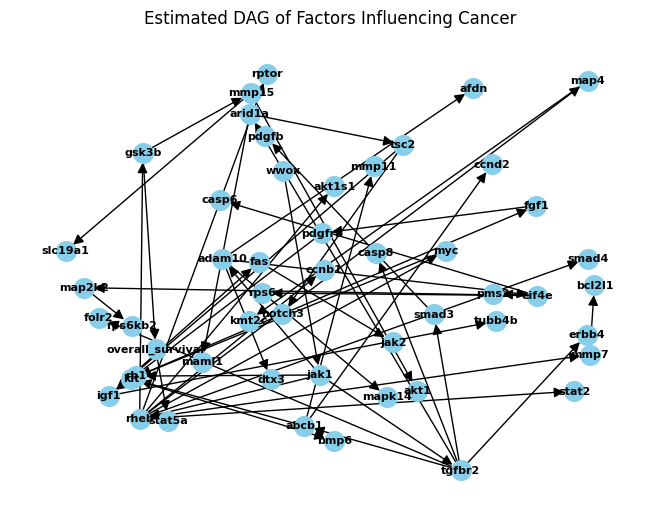

Processing fold 1/5...
AUC score for fold 1: 0.527588813303099
Processing fold 2/5...
AUC score for fold 2: 0.5289573143619387
Processing fold 3/5...
AUC score for fold 3: 0.5321098346875874
Processing fold 4/5...
AUC score for fold 4: 0.5246866096866097
Processing fold 5/5...
AUC score for fold 5: 0.5358149065141296
Average AUC score across 5 folds: 0.530


ImportError: cannot import name 'BayesianNetwork' from 'pgmpy.estimators' (/usr/local/lib/python3.10/dist-packages/pgmpy/estimators/__init__.py)